In [184]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy.stats
from statannotations.Annotator import Annotator

matplotlib.rcParams.update({'font.size': 16})

In [654]:
query_name = 'activation' #outrider_overexpressed/outrider_underexpressed/activation

query_name += '_most_significant'

In [655]:
promoter_suffix = '2000_symm'

In [656]:
activation_csv = '/s/project/mll/sergey/effect_prediction/outrider/input_data/activation/res_filter_out_all.csv.gz' 

In [657]:
outrider_csv = '/s/project/mll/sergey/effect_prediction/outrider/input_data/outrider/outrider_all_v33b.csv.gz' 

In [658]:
promoter_mutations_tsv = f'/s/project/mll/sergey/effect_prediction/promoter_mutations/{promoter_suffix}/MLL_filtering/mutations_filter_counts.tsv'

coding_mutations_tsv = '/s/project/mll/sergey/effect_prediction/promoter_mutations/coding_mutations/MLL_filtering/filter_counts/mutations_filter_counts.tsv'

vcf_matching = '/s/project/mll/sergey/effect_prediction/promoter_mutations/analysed_samples/analysed_vcfs.tsv'

splicing_tsv = '/s/project/mll/sergey/MLL_data/processed/significant_splicing.tsv'

structural_tsv = '/s/project/mll/sergey/MLL_data/processed/vale.svs.filtered.tsv.gz'

copy_number_tsv = '/s/project/mll/sergey/MLL_data/processed/cnv_mll_NoOverlapNoMaxlen.tsv'

aml_variants_tsv='/s/project/mll/sergey/effect_prediction/outrider/input_data/20221207_paper_AML_variants.txt'

In [659]:
output_dir = '/s/project/mll/sergey/effect_prediction/promoter_mutations/res/'

In [660]:
if 'activation' in query_name:
    
    results_df = pd.read_csv(activation_csv, usecols=[0,1,3,4]) 
    
elif 'outrider' in query_name:
    
    results_df = pd.read_csv(outrider_csv, usecols=[0,1,3,4]) 
    
    if 'overexpressed' in query_name:
        
        results_df = results_df[results_df.l2fc>0]
        
    elif 'underexpressed' in query_name:
        
        results_df = results_df[results_df.l2fc<0]
else:
    
    activation_df = pd.read_csv(activation_csv, usecols=[0,1,3,4]) 
    outrider_df = pd.read_csv(outrider_csv, usecols=[0,1,3,4]) 
    
    results_df = pd.concat([outrider_df,activation_df])

In [661]:
matching_df = pd.read_csv(vcf_matching, header=None, sep='\t', names=['array_id','vcf']).set_index('vcf').squeeze()

In [662]:
#results_df = results_df[results_df.sampleID.isin(matching_df)]

In [663]:
if 'most_significant' in query_name:
    normal_df = results_df[results_df.padjust>=0.05]
    abnormal_df = results_df[results_df.padjust<0.05].sort_values(by=['padjust']).groupby('sampleID').apply(lambda x: x.iloc[:3]).droplevel(0)
    results_df = pd.concat([normal_df,abnormal_df])

In [664]:
(results_df.padjust<0.05).sum()

3378

In [665]:
results_df.drop_duplicates(subset=['sampleID','geneName'], inplace=True)

In [666]:
print(f'Sample-gene pairs: {len(results_df)}, samples: {len(results_df.sampleID.unique())}, genes: {len(results_df.geneName.unique())}')

Sample-gene pairs: 22617035, samples: 3760, genes: 6017


In [667]:
results_df.rename(columns={'sampleID':'array_id'}, inplace=True)

In [668]:
promoter_mutations = pd.read_csv(promoter_mutations_tsv, header=None, sep='\t', usecols=[5,6], names=['geneName','vcf']) #promoter mutations after filtering

promoter_mutations['promoter_variant'] = 1

In [669]:
coding_mutations = pd.read_csv(coding_mutations_tsv, header=None, sep='\t', usecols=[5,6,7,8,9,10,11,12], 
    names=['frameshift_variant', 'stop_gained', 'NMD_transcript_variant', 'splice_donor_variant', 'splice_acceptor_variant','splice_region_variant', 'geneName','vcf']) #promoter mutations after filtering

In [670]:
#coding_mutations['splice_site_variant'] = coding_mutations.splice_acceptor_variant + coding_mutations.splice_donor_variant
coding_mutations['splice_related_variant'] = coding_mutations.splice_acceptor_variant + coding_mutations.splice_donor_variant + coding_mutations.splice_region_variant

coding_mutations.drop(columns=['NMD_transcript_variant', 'splice_donor_variant', 'splice_acceptor_variant','splice_region_variant'], inplace=True)

In [671]:
mutations_df = promoter_mutations.merge(coding_mutations, how='outer')

In [672]:
# remove genes with mutations explained by MLL

#mutations_mll = pd.read_csv(aml_variants_tsv, sep='\t')

#matching_genes = pd.read_csv('/s/project/mll/sergey/effect_prediction/promoter_mutations/ensemble_to_HGNC_GRCh38.tsv.gz', sep='\t', 
#                      header=None, names=['geneName', 'symbol'], usecols=[0,1], skiprows=1)

#matching_genes = matching_genes[~matching_genes.symbol.isna()]

#mutations_mll = mutations_mll[['array_id','symbol']].merge(matching_genes)

#results_df = results_df.merge(mutations_mll[['array_id','geneName']],
#                   indicator = True, how='left').loc[lambda x : x['_merge']=='left_only'].drop(columns='_merge')

In [673]:
mutations_df['array_id'] = mutations_df.vcf.map(matching_df) #mapping between vcf and MLL array_id 

In [674]:
mutations_df.geneName = mutations_df.geneName.apply(lambda x: x.split(',') if ',' in x else x)

In [675]:
mutations_df = mutations_df.explode('geneName') #split by gene where multiple genes per mutation

In [676]:
mutations_counts = mutations_df.drop(columns='vcf').groupby(['array_id','geneName']).sum().astype(bool)

In [677]:
results_df = results_df.merge(mutations_counts.reset_index(), how='left')

In [678]:
results_df = results_df.fillna(False)

In [679]:
#mark sample-gene pairs with splicing outliers

splicing_df = pd.read_csv(splicing_tsv, sep='\t')[['geneName','array_id']].drop_duplicates()

results_df = results_df.merge(splicing_df,
                   indicator = True, how='left').loc[lambda x : x['_merge']!='right_only'].rename(columns={'_merge':'splicing_outlier'})

In [680]:
#mark sample-gene pairs with structural variants

sv_df = pd.read_csv(structural_tsv, sep='\t')[['geneName','array_id','svtype']].drop_duplicates()

sv_df = sv_df.groupby(['array_id','geneName']).svtype.apply(lambda x:','.join(x)).reset_index()

results_df = results_df.merge(sv_df[['geneName','array_id','svtype']],
                   indicator = True, how='left').loc[lambda x : x['_merge']!='right_only'].rename(columns={'_merge':'structural_variant'})

In [681]:
#mark sample-gene pairs with copy number variants

cnv_df = pd.read_csv(copy_number_tsv, sep='\t')[['geneName','array_id','call']].drop_duplicates()

cnv_df = cnv_df.groupby(['array_id','geneName']).call.apply(lambda x:','.join(x)).reset_index()

results_df = results_df.merge(cnv_df[['geneName','array_id','call']],
                   indicator = True, how='left').loc[lambda x : x['_merge']!='right_only'].rename(columns={'_merge':'copy_number_variant'})

In [682]:
results_df['abnormal'] = results_df.padjust<0.05
results_df['abnormal'].sum()

3378

In [683]:
results_df['structural_variant'] = results_df.structural_variant == 'both'
results_df['splicing_outlier'] = results_df.splicing_outlier == 'both'
results_df['copy_number_gain'] = (results_df.copy_number_variant == 'both')&(results_df.call.isin(('+','+,-','-,+')))
results_df['copy_number_loss'] = (results_df.copy_number_variant == 'both')&(results_df.call.isin(('-','+,-','-,+')))
results_df['copy_number'] = (results_df.copy_number_gain)|(results_df.copy_number_loss)

In [684]:
((results_df['abnormal'])&(results_df['copy_number'])).sum()/results_df['abnormal'].sum()*100

9.532267613972765

In [685]:
#results_df['stop_gained_NMD'] = (results_df.stop_gained) & (results_df.NMD_transcript_variant)

# Summarize results

In [686]:
reasons = ['promoter_variant', 'structural_variant', 'splice_related_variant', 
           'copy_number_gain', 'copy_number_loss', 'copy_number', 'frameshift_variant', 'stop_gained']

res = []

for conf in (False,True):

    for reason in reasons:
        
        print(conf, reason)

        if conf==False:

            #if not 'copy_number' in reason:
            flt = ~results_df[[x for x in reasons if x!=reason]].sum(axis=1).astype(bool)
            #else:
            #    flt = ~results_df[[x for x in reasons if x!=reason and not 'copy_number' in x]].sum(axis=1).astype(bool)
                
            contig_table = pd.crosstab(results_df.loc[flt][reason].astype(str), results_df.loc[flt]['abnormal'].astype(str), margins=True)
        else:
            contig_table = pd.crosstab(results_df[reason].astype(str), results_df['abnormal'].astype(str), margins=True)
            
        if not 'True' in contig_table.index:
            contig_table.loc['True'] = 0
        
        counts_normal = contig_table.loc['All','False']
        counts_abnormal = contig_table.loc['All','True']
            
        mutated_activ = contig_table.loc['True','True']
        nonmutated_activ = contig_table.loc['True','False']
        
        #contig_table = contig_table+1 #correct for 0s
        
        odds_ratio,p_value = scipy.stats.fisher_exact(contig_table.iloc[:2,:2])

        res.append((conf,reason,counts_normal, counts_abnormal, 
                    mutated_activ, nonmutated_activ, odds_ratio, p_value))
    
    #print(f'Fraction of sample-gene pairs with {reason} among abnormally expressed: {mutated_activ_prop:.3}')
    #print(f'Fraction of sample-gene pairs with {reason} among normally expressed: {nonmutated_activ_prop:.3}')

False promoter_variant
False structural_variant
False splice_related_variant
False copy_number_gain
False copy_number_loss
False copy_number
False frameshift_variant
False stop_gained
True promoter_variant
True structural_variant
True splice_related_variant
True copy_number_gain
True copy_number_loss
True copy_number
True frameshift_variant
True stop_gained


In [687]:
res = pd.DataFrame(res, columns=['confounders', 'mutation', 'total pairs normal', 'total pairs abnormal',
                                 'mutations in abnomal', 'mutations in normal',
                                 'odds ratio', 'p-value'])

res.mutation = res.mutation.apply(lambda x:x.replace('_variant',''))

In [688]:
res.to_csv(output_dir + query_name + '.csv', index=None)

In [689]:
#res['Odds_ratio'] = res['Frac. in anomal expr.']/res['Frac. in normal expr.']

In [650]:
#res.iloc[:,4:7] = res.iloc[:,4:7].applymap(lambda x: f'{x:.3}')

# Structural variants

In [651]:
flt = ~results_df[[x for x in reasons if x!='structural_variant']].sum(axis=1).astype(bool)

sv_df = results_df.loc[flt & results_df.structural_variant & results_df.abnormal]
sv_df['GE_change'] = sv_df.l2fc.apply(lambda x:x>0)

/scratch/tmp/l_vilov/ipykernel_586971/582213760.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sv_df['GE_change'] = sv_df.l2fc.apply(lambda x:x>0)


In [226]:
from statannotations.stats.StatTest import StatTest

def fishers_test(x,y):
    contig_table = ((sum(x),len(x)-sum(x)),(sum(y),len(y)-sum(y)))
    return scipy.stats.fisher_exact(contig_table)

fishers = StatTest(fishers_test, "Fisher's exact test", 'fischer', 'statistic')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

INS vs. DEL: Fisher's exact test with Benjamini-Hochberg correction, P_val:3.375e-02 statistic=2.016e+00
DUP vs. DEL: Fisher's exact test with Benjamini-Hochberg correction, P_val:7.690e-06 statistic=2.608e+00


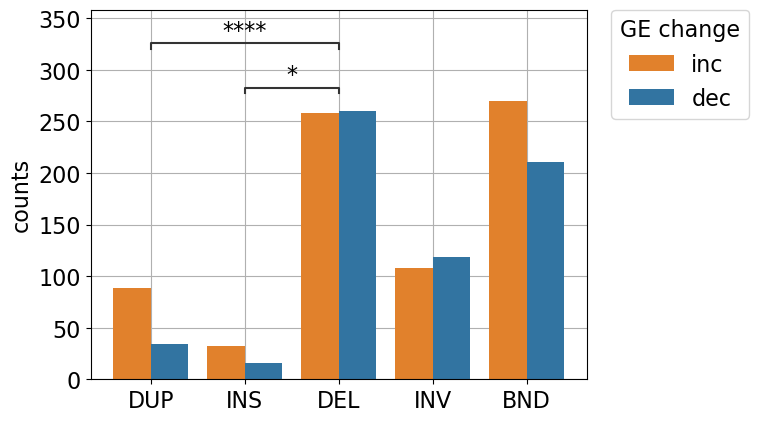

In [247]:
inc_df = sv_df.groupby('svtype').l2fc.agg(lambda x:sum(x>0)).loc[['DUP','INS','DEL','INV','BND']].reset_index()
inc_df['GE change'] = 'inc'
dec_df = sv_df.groupby('svtype').l2fc.agg(lambda x:sum(x<0)).loc[['DUP','INS','DEL','INV','BND']].reset_index()
dec_df['GE change'] = 'dec'
df = pd.concat([inc_df,dec_df])

fig, ax = plt.subplots()

ax=sns.barplot(x='svtype', y='l2fc', hue='GE change', data=df,palette=['tab:orange', 'tab:blue']) 

box_pairs=[ ("DEL", "INS"),("DUP", "DEL") ]

annotator = Annotator(ax, box_pairs, data=sv_df, x="svtype", y="GE_change", order=['DUP','INS','DEL','INV','BND'])
annotator.configure(test=fishers, text_format='star', loc='inside', comparisons_correction="BH")
#annotator.configure(test='t-test_paired', text_format='star', loc='inside', comparisons_correction="BH")

annotator.apply_and_annotate()

ax.grid(True)
ax.set_axisbelow(True)
ax.set_ylabel('counts')
ax.set_xlabel('')

ax.legend(bbox_to_anchor=(1.35, 1.03), title='GE change')

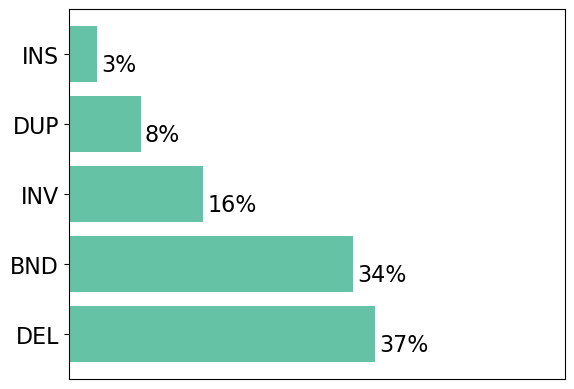

In [248]:
vartype_c = sv_df.svtype.value_counts()
y = vartype_c/vartype_c.sum()*100

fig, ax = plt.subplots()

ax.barh(vartype_c.index,y,color='#66C2A5')

ax.set_xlim([0,60])

#ax.set_yticks(ax.get_yticks())
#ax.set_yticklabels([str(int(x))+'%' for x in ax.get_yticks()]);

ax.set_xticks([])

for i, v in enumerate(y):
    plt.text(v + 0.5,i - 0.25,  str(int(v))+'%')

# Copy number

In [250]:
flt = ~results_df[[x for x in reasons if x!='copy_number_variant']].sum(axis=1).astype(bool)

cnv_df = results_df.loc[flt & results_df.copy_number_variant & results_df.abnormal,['call','l2fc']]

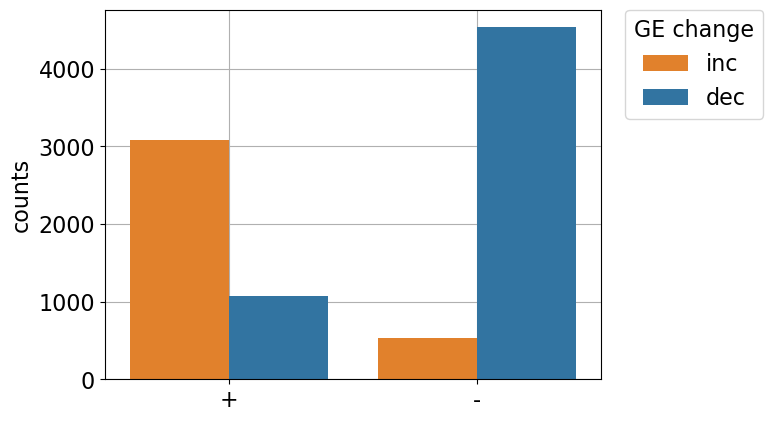

In [252]:
inc_df = cnv_df.groupby('call').l2fc.agg(lambda x:sum(x>0)).reset_index()
inc_df['GE change'] = 'inc'
dec_df = cnv_df.groupby('call').l2fc.agg(lambda x:sum(x<0)).reset_index()
dec_df['GE change'] = 'dec'
df = pd.concat([inc_df,dec_df])

fig, ax = plt.subplots()

sns.barplot(x='call', y='l2fc', hue='GE change', data=df,palette=['tab:orange', 'tab:blue']) 

ax.grid(True)
ax.set_axisbelow(True)
ax.set_ylabel('counts')
ax.set_xlabel('')

ax.legend(bbox_to_anchor=(1.35, 1.03), title='GE change')

# Average change

In [90]:
reasons = ['promoter_variant', 'splicing_variant', 
           'frameshift_variant', 'NMD_transcript_variant', 'stop_gained']

for reason in reasons:
        
    flt = ~results_df[[x for x in reasons if x!=reason]].sum(axis=1).astype(bool)
    
    mean_l2fc_abnormal = results_df.loc[(flt)&(results_df.abnormal)&(results_df[reason])].l2fc.mean()
    
    print(reason, f'{mean_l2fc_abnormal:.2f}')

promoter_variant 1.10
splicing_variant 0.37
frameshift_variant -0.27
NMD_transcript_variant -0.40
stop_gained -0.42
